<a href="https://colab.research.google.com/github/rohit-447/Py-Torch-Learning/blob/main/Pytorch_CNN_Food101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working on Food101 Dataset as Custom Dataset


In [2]:
#@title Import of modules
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import Food101
import matplotlib.pyplot as plt
from pathlib import Path
torch.__version__, torchvision.__version__

('2.6.0+cu124', '0.21.0+cu124')

In [4]:
#@title Download of DataSet
FOOD101=Food101(root='data', download=True)

100%|██████████| 5.00G/5.00G [05:19<00:00, 15.7MB/s]


In [5]:
#@title Walk through Directory
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

#going through folder
PATH=Path('data')
walk_through_dir(PATH)

There are 1 directories and 1 files in data
There are 2 directories and 2 files in data/food-101
There are 0 directories and 6 files in data/food-101/meta
There are 101 directories and 0 files in data/food-101/images
There are 0 directories and 1000 files in data/food-101/images/eggs_benedict
There are 0 directories and 1000 files in data/food-101/images/ramen
There are 0 directories and 1000 files in data/food-101/images/oysters
There are 0 directories and 1000 files in data/food-101/images/omelette
There are 0 directories and 1000 files in data/food-101/images/miso_soup
There are 0 directories and 1000 files in data/food-101/images/hot_and_sour_soup
There are 0 directories and 1000 files in data/food-101/images/ravioli
There are 0 directories and 1000 files in data/food-101/images/ice_cream
There are 0 directories and 1000 files in data/food-101/images/dumplings
There are 0 directories and 1000 files in data/food-101/images/sushi
There are 0 directories and 1000 files in data/food-10

In [6]:
#@title Split of Dataset into Train and Test and save them.
from sklearn.model_selection import train_test_split
import os
import shutil
import tqdm.auto as tqdm
DATA_ORIGINAL_PATH='data/food-101'
IMAGES='images'
DATA_SPLIT_PATH='Dataset_new'
if not os.path.exists(DATA_SPLIT_PATH):
  os.makedirs(DATA_SPLIT_PATH, exist_ok=True)

source_dir=os.path.join(DATA_ORIGINAL_PATH,IMAGES)
train_dir=os.path.join(DATA_SPLIT_PATH, 'train')
test_dir=os.path.join(DATA_SPLIT_PATH, 'test')
val_dir=os.path.join(DATA_SPLIT_PATH, 'val')

#clear the dir if it exists
for dir_path in [train_dir, test_dir, val_dir]:
  if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
  os.makedirs(dir_path)

#Iterrate over the classes of images
for  class_name in tqdm.tqdm(os.listdir(source_dir), desc="Processing Classes", unit="class"):
  class_path= os.path.join(source_dir, class_name)
  if not os.path.isdir(class_path):
    continue

  #list all images in class folder
  images=[os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith('.jpg')]
  dataset_train, dataset_test=train_test_split(images, test_size=0.2, random_state=42)

  #copy the train test files and save them
  def copy_files(file_list, save_path):
    save_root=os.path.join(save_path, class_name)
    os.makedirs(save_root, exist_ok=True)
    for f in file_list:
      shutil.copy(f, os.path.join(save_root, os.path.basename(f)))

  copy_files(dataset_train, train_dir)
  copy_files(dataset_test, test_dir)
print(f'Dataset Suceesfully split into Train and Test')

Processing Classes:   0%|          | 0/101 [00:00<?, ?class/s]

Dataset Suceesfully split into Train and Test


In [9]:
#checking dataset Split
walk_through_dir(DATA_SPLIT_PATH)

There are 3 directories and 0 files in Dataset_new
There are 0 directories and 0 files in Dataset_new/val
There are 101 directories and 0 files in Dataset_new/test
There are 0 directories and 200 files in Dataset_new/test/eggs_benedict
There are 0 directories and 200 files in Dataset_new/test/ramen
There are 0 directories and 200 files in Dataset_new/test/oysters
There are 0 directories and 200 files in Dataset_new/test/omelette
There are 0 directories and 200 files in Dataset_new/test/miso_soup
There are 0 directories and 200 files in Dataset_new/test/hot_and_sour_soup
There are 0 directories and 200 files in Dataset_new/test/ravioli
There are 0 directories and 200 files in Dataset_new/test/ice_cream
There are 0 directories and 200 files in Dataset_new/test/dumplings
There are 0 directories and 200 files in Dataset_new/test/sushi
There are 0 directories and 200 files in Dataset_new/test/steak
There are 0 directories and 200 files in Dataset_new/test/escargots
There are 0 directories a

Image Path: Dataset_new/train/chocolate_mousse/2815941.jpg
Class Height: 512 and Width: 512


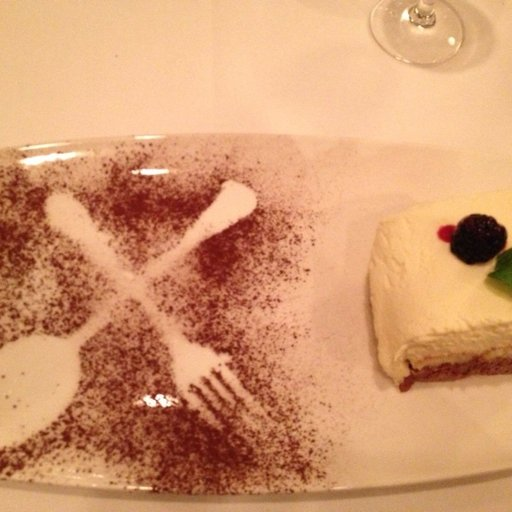

In [7]:
#@title Visulisation of Random Images
import random
import PIL
import glob
DATASET=Path('Dataset_new')
random_image=list(DATASET.glob('*/*/*.jpg'))
random_image_path=random.choice(random_image)
random_image_class=random_image_path.parent.stem
img=PIL.Image.open(random_image_path)
print(f'Image Path: {random_image_path}')
print(f'Class Height: {img.height} and Width: {img.width}')
img

In [8]:
#@title Device Agonistic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [14]:
#@title Data Transformation and Augmentation
from torchvision import transforms
data_transformation= transforms.Compose([transforms.Resize(size=(64,64)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor()])
